# Parameter optimization on DynapSEtorch

In this example we will use DynapSEtorch to optimise the parameters of the DynapSE neural model to produce a desired output firing rate based on a given input. Making use of the advantages of PyTorch for autodifferentiation.

In [1]:
import torch
import torch.nn as nn
import numpy as np

import time

import matplotlib.pyplot as plt

from dynapsetorch.model import *
from tqdm import tqdm

torch.autograd.set_detect_anomaly(True)

timestep = 0.1 * 1e-3

## Input pattern generation

First we are going to create or input spike train for the network. It would be a regular firing rate of 100hz

In [2]:
# Parameters
pulse_start = 0  # second - Start time of input (Default: 0)
pulse_stop = 1  # second - Stop time of input (Default: 5)
inp_duration = 0.1  # second - Simulation duration (Default: 5)
rate = 100  # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine)
##################

spikes = torch.zeros(int(inp_duration / timestep))
dt = int((1 / timestep) / rate)
spikes[pulse_start * int(1 / timestep) : pulse_stop * int(1 / timestep) : dt] = 1.0

input = spikes.unsqueeze(1).cuda()

## Network creation

Next we are going to create our network. It would be 1 neuron with an **AMPA** synapse with an initial weight value of $3$. After creating the network, we create the optimizer, that in our case would be an Adamax optimizer with $\beta_1=0.99$ and $\beta_2=0.999$ and a learning rate of $5e^{-2}$

In [3]:
model = AdexLIF(1).cuda()
model.dt = timestep
model.weight_nmda.data = torch.ones(1).cuda() * 0
model.weight_ampa.data = torch.ones(1).cuda() * 3
model.weight_gaba_a.data = torch.ones(1).cuda() * 0
model.weight_gaba_b.data = torch.ones(1).cuda() * 0
optimizer = torch.optim.Adamax(model.parameters(), lr=5e-2, betas=(0.99, 0.999))

To train or network, we are going to define our loss function as the MSE error of the number of output spikes and the desired output spikes (4). During the simulation, we accumulate the spikes produced by the neuron in the variable *loss_out*, after the simulation, with the loss value calculated, the gradients of the network variables are calculated and updated via the optimizer. 

In [4]:
def train(model, input, optimizer):
    pbar = tqdm(range(10))
    for epoch in pbar:
        loss_out = 0
        model.state = model.init_state(input[0])
        for t in range(input.shape[0]):
            S = model(input_ampa=input[t])
            loss_out += S
        loss = torch.mean((loss_out - 4) ** 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"Spikes count": loss_out.item(), "Loss": loss.item()})

For testing the network we only need to simulate it and the record the desired variables (Synaptic current, Soma current and output)

In [5]:
@torch.no_grad()
def test(model, input):
    output = []
    output_ampa = []
    output_Isoma = []
    model.state = model.init_state(input[0])
    for t in range(input.shape[0]):
        output_ampa.append(model.state.Iampa.cpu())
        output_Isoma.append(model.state.Isoma_mem.cpu())
        S = model(input_ampa=input[t])
        output.append(S.cpu())
    output = torch.stack(output, dim=1)
    output_ampa = torch.stack(output_ampa, dim=1)
    output_Isoma = torch.stack(output_Isoma, dim=1)

    return output, output_ampa, output_Isoma

We can also visualize the parameters that are going to be trained.

In [6]:
for n, p in model.named_parameters():
    if p.requires_grad:
        print(n)

weight_nmda
weight_ampa
weight_gaba_a
weight_gaba_b


## Run the simulation

In [7]:
print("Calculating output before optimization...")
start = time.time()
output_before, output_ampa_before, output_Isoma_before = test(model, input)
end = time.time()
print("Time elapsed: ", end - start)

print("Optimizing...")
train(model, input, optimizer)

print("Calculating output after optimization")
start = time.time()
output_after, output_ampa_after, output_Isoma_after = test(model, input)
end = time.time()
print("Time elapsed: ", end - start)

Calculating output before optimization...
Time elapsed:  5.239625692367554
Optimizing...


100%|██████████| 10/10 [04:16<00:00, 25.62s/it, Spikes count=4, Loss=0]


Calculating output after optimization
Time elapsed:  5.114797830581665


## Visualization

Finally we can visualize the result. On the black line we have the simulation result before the parameters optimization. As we can se, the neuron produce a total of 3 spikes. The blue line represent the soma current after the parameters optimization. This time the network produced the desired number of spikes (4)

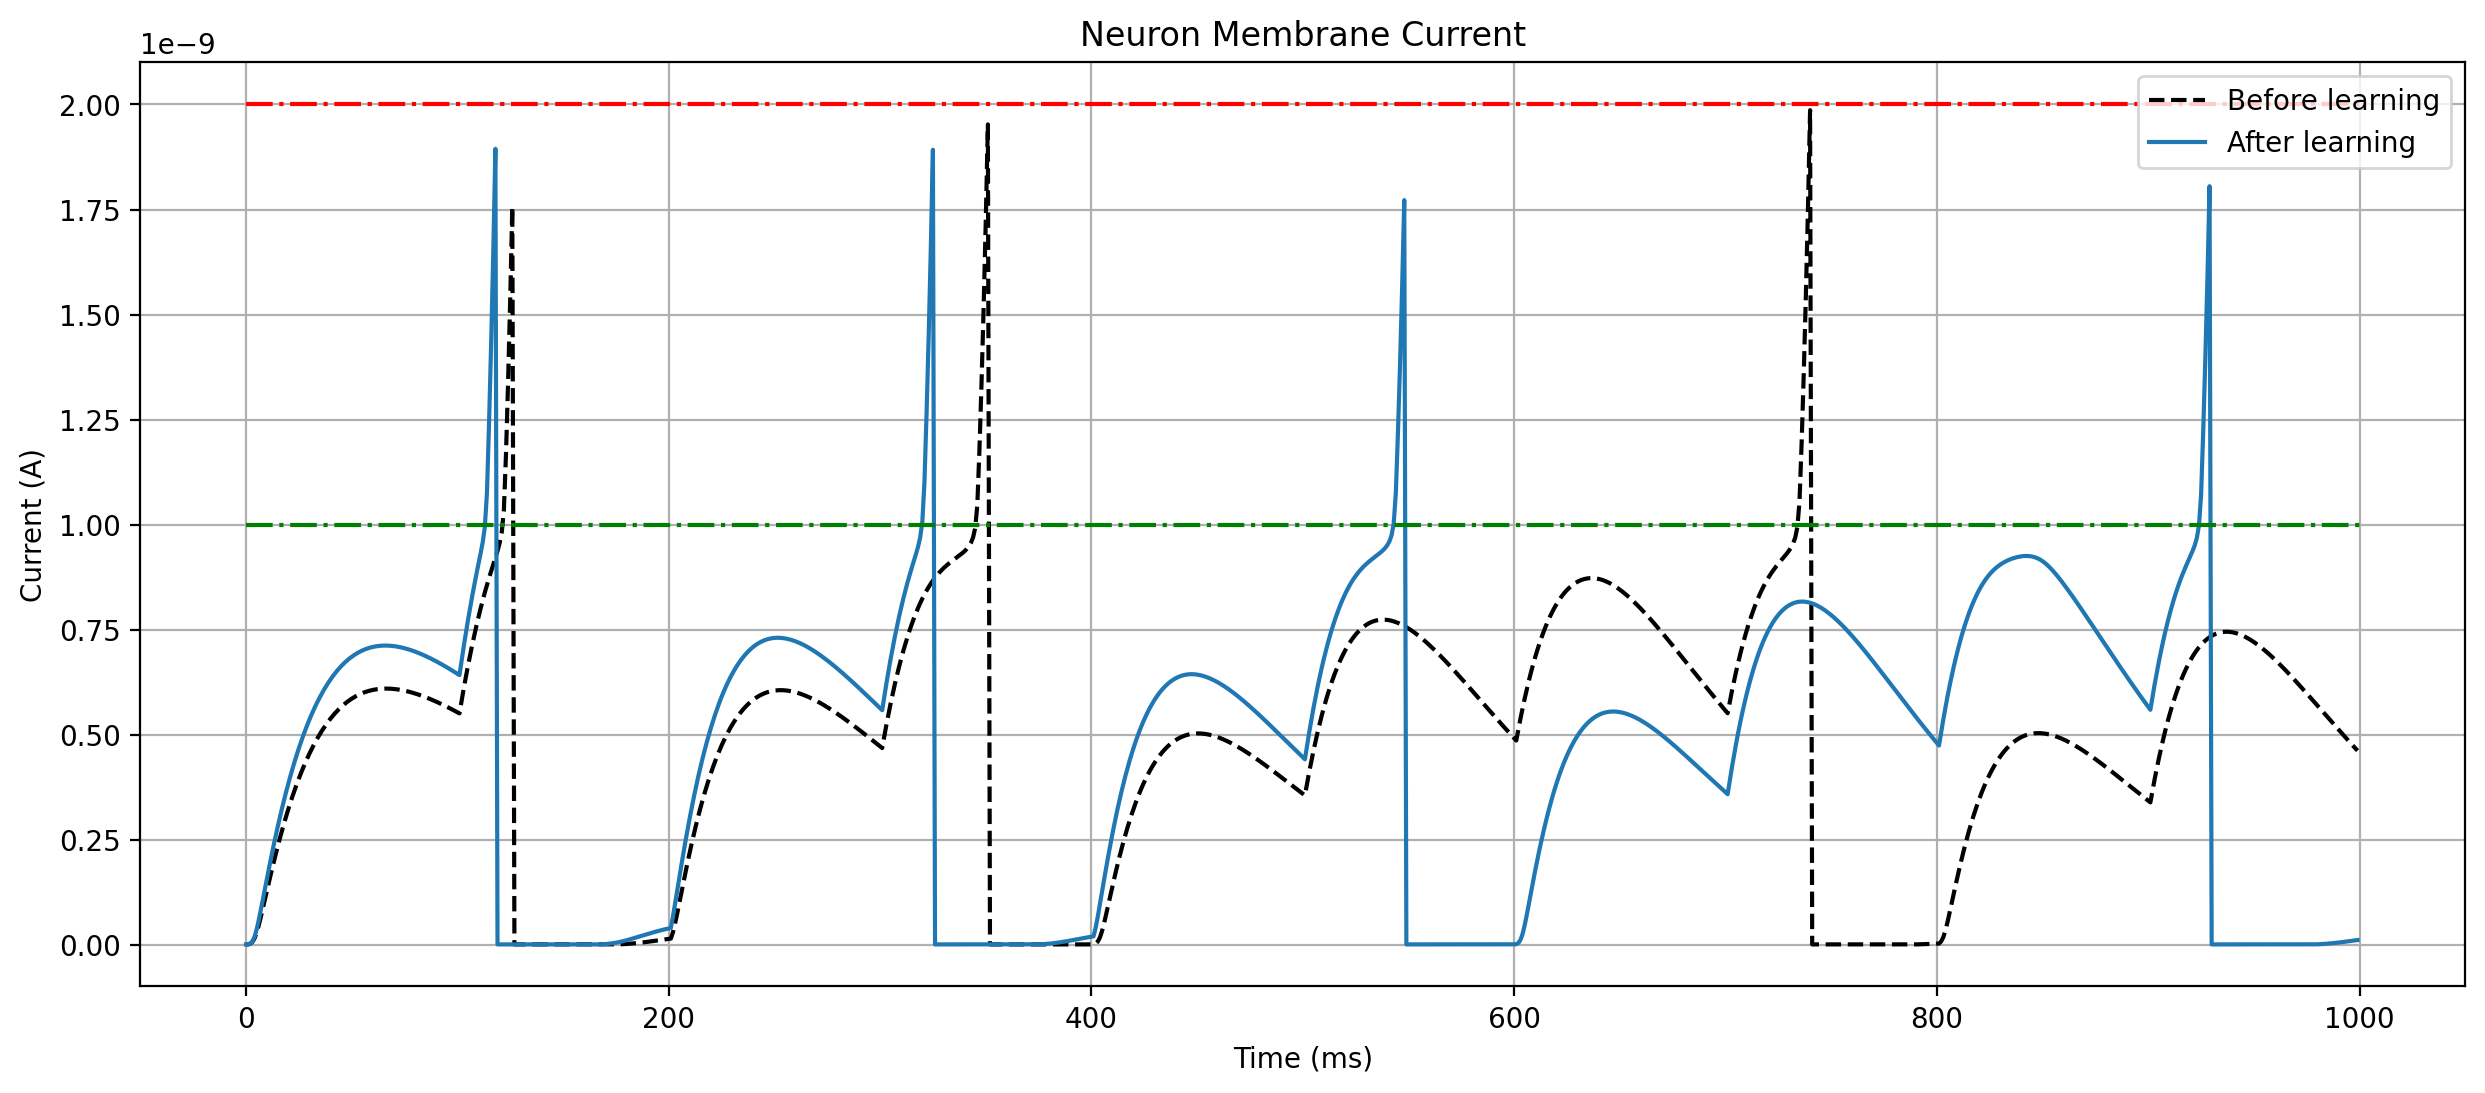

In [8]:
tstart = int(00 * (ms / timestep))  # ms
tend = int(100 * (ms / timestep))  # ms
##################

# Plotting
plt.figure(figsize=(15, 6), dpi=200)
plt.subplots_adjust(hspace=2)

plt.subplot(111)
plt.plot(output_Isoma_before[0].detach(), "--k")
plt.plot(output_Isoma_after[0].detach())
plt.hlines(
    y=model.Isoma_th.detach().cpu().numpy(),
    xmin=0,
    xmax=int(inp_duration / timestep),
    color="r",
    linestyles="-.",
)
plt.hlines(
    y=model.Isoma_pfb_th.detach().cpu().numpy(),
    xmin=0,
    xmax=int(inp_duration / timestep),
    color="g",
    linestyles="-.",
)
plt.title("Neuron Membrane Current")
plt.ylabel("Current (A)")
plt.legend(["Before learning", "After learning"])
plt.xlabel("Time (ms)")
plt.grid(True)

plt.show()